In [99]:
#Count the number of days with temperature minimum above 293.15K 
import xarray as xr
import numpy as np
import os
import glob
import pandas as pd
import datetime

input_pattern = 'tasminAdjust_alpes_day_*.nc'
input_files = sorted(glob.glob(input_pattern))
tropical_threshold = 293.15

for input_file in input_files:
    base_name = os.path.basename(input_file)
    output_file = f"tropical_days_per_year_{base_name.split('tasminAdjust_alpes_day_')[-1].replace('.nc', '')}.nc"
    print(f"\nProcessing {input_file} ...")

    # Open the dataset
    ds = xr.open_dataset(input_file)

    # Create a boolean mask for temperatures above tropical
    above_tropical = ds['tasminAdjust'] > tropical_threshold

    # Group by year and count
    tropical_days_per_year = above_tropical.astype(int).groupby('time.year').sum(dim='time')

    # Make a mask for years (and grid cells) with all missing data
    count_days_per_year = ds['tasminAdjust'].groupby('time.year').count(dim='time')
    missing_mask = count_days_per_year == 0  # True where there was no data at all

    # Convert to floats so NaNs can be present
    tropical_days_values = tropical_days_per_year.values.astype(float)
    # Set to NaN where there was no data
    tropical_days_values[missing_mask.values] = np.nan

    # Create a new dataset with the results
    ds_output = xr.Dataset({
        'tropical_days': (['year', 'y', 'x'], tropical_days_values)
    })
    
    # Set coordinates
    ds_output = ds_output.assign_coords({
        'year': tropical_days_per_year.year.values.astype(int),
        'x': ds.coords['x'],
        'y': ds.coords['y']
    })
    
    # Add attributes
    ds_output['tropical_days'].attrs['long_name'] = 'Count of days with min daily temperature above 293.15K'
    ds_output['tropical_days'].attrs['units'] = 'days'
    ds_output['tropical_days'].attrs['threshold'] = '293.15K'
    
    ds_output['year'].attrs['long_name'] = 'year'

    # Save to NetCDF
    ds_output.to_netcdf(output_file)
    
    ds.close()


Processing tasminAdjust_alpes_day_19900101-19991231.nc ...

Processing tasminAdjust_alpes_day_20000101-20091231.nc ...

Processing tasminAdjust_alpes_day_20100101-20141231.nc ...

Processing tasminAdjust_alpes_day_20150101-20191231.nc ...

Processing tasminAdjust_alpes_day_20200101-20291231.nc ...

Processing tasminAdjust_alpes_day_20300101-20391231.nc ...

Processing tasminAdjust_alpes_day_20400101-20491231.nc ...

Processing tasminAdjust_alpes_day_20500101-20591231.nc ...

Processing tasminAdjust_alpes_day_20600101-20691231.nc ...

Processing tasminAdjust_alpes_day_20700101-20791231.nc ...

Processing tasminAdjust_alpes_day_20800101-20891231.nc ...

Processing tasminAdjust_alpes_day_20900101-20991231.nc ...

Processing tasminAdjust_alpes_day_21000101-21001231.nc ...


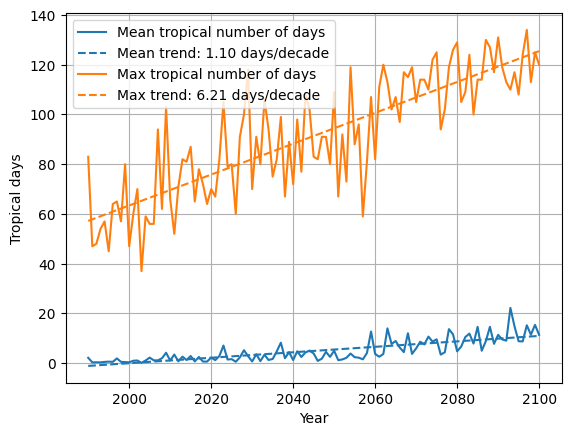

In [100]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Quick plot
nc_files = sorted(glob.glob('tropical_days_per_year*.nc'))
ds = xr.open_mfdataset(nc_files, decode_times=False).load()

years = ds.year.values
mean_fd = ds.tropical_days.mean(dim=['x', 'y']).values
max_fd = ds.tropical_days.max(dim=['x', 'y']).values

fig, ax = plt.subplots()

# Plot mean
mean_plot = ax.plot(years, mean_fd, label='Mean tropical number of days')[0]
slope_mean, intercept_mean, r_value, p_value, std_err = linregress(years, mean_fd)
# Convert slope to days/decade
slope_per_decade_mean = slope_mean * 10
ax.plot(
    years,
    intercept_mean + slope_mean*years,
    '--',
    color=mean_plot.get_color(),
    label=f'Mean trend: {slope_per_decade_mean:.2f} days/decade'
)

# Plot max
max_plot = ax.plot(years, max_fd, label='Max tropical number of days')[0]
slope_max, intercept_max, r_value, p_value, std_err = linregress(years, max_fd)
# Convert slope to days/decade
slope_per_decade_max = slope_max * 10
ax.plot(
    years,
    intercept_max + slope_max*years,
    '--',
    color=max_plot.get_color(),
    label=f'Max trend: {slope_per_decade_max:.2f} days/decade'
)

ax.legend()
ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Tropical days')
plt.show()

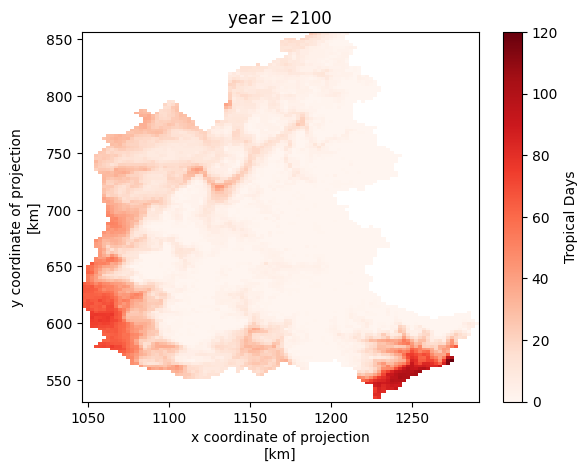

In [101]:
nc_files = sorted(glob.glob('tropical_days_per_year*.nc'))
ds = xr.open_mfdataset(nc_files, decode_times=False).load()
ds
ds.tropical_days.sel(year=2100).plot(cmap='Reds', cbar_kwargs={'label': 'Tropical Days'})